# Lab Session II: Implement your own GMM
*Author: Yiru Zhang*

*Computer Science Departement*

*Ecole Supérieure d'Ingénieur Léonard-de-Vinci*

In this lab session, you will implement GMM, a clustering algorithm. Even though many well maintained toolboxes exist (such as scikit learn), you must implement these two algorithms from scratch, for a better comprehension of the mathematical behind. You will build the following competences:
1.	A better understanding of algorithms GMM.
2.	Implementation of EM (expectation maximization) as an optimization process

This work should be done by group of **TWO students (maximum)**.
Please submit GMM and SVM (Lab Session III) together as one submission.

## Working on Generated data to simplify the implementation.

<a id='data_generation'></a>
### Data generation

Working on artificially generated data is a common manipulation when testing an algorithm. A main advantage of a such manipulation is that all ground truth knowledge of the data is known, therefore evaluation on the tested algorithm is straitforward.

The function make_blobs generates isotropic (spherical) gaussian blobs. To obtain anisotropic (elliptical) gaussian blobs one has to define a linear transformation.

Elliptical gaussian implies that the distribution on two axis are correlated, i.e., covariance $Cov(X,Y) \neq 0$


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

n_samples = 1500
random_state = 170
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_aniso = np.dot(X, transformation)  # Anisotropic blobs
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)  # Unequal variance
X_filtered = np.vstack(
    (X[y == 0][:500], X[y == 1][:100], X[y == 2][:10])
)  # Unevenly sized blobs
y_filtered = [0] * 500 + [1] * 100 + [2] * 10

<a id='data_plot'></a>
#### Plot the data


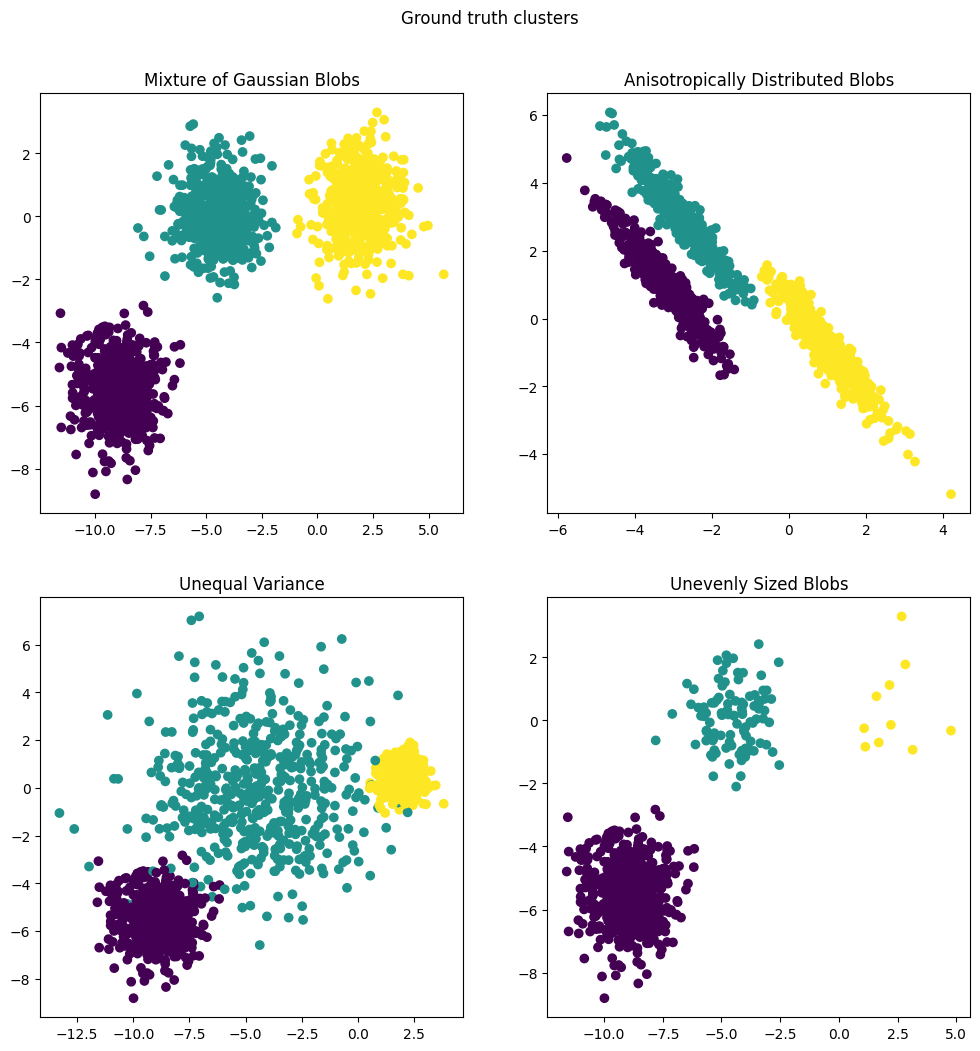

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

axs[0, 0].scatter(X[:, 0], X[:, 1], c=y)
axs[0, 0].set_title("Mixture of Gaussian Blobs")

axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y)
axs[0, 1].set_title("Anisotropically Distributed Blobs")

axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied)
axs[1, 0].set_title("Unequal Variance")

axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered)
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("Ground truth clusters").set_y(0.95)
plt.show()

### implementation of GMM

For further usage of the method, you should implement the algorithm within a python class.
The skeleton is provided below. you should complete and test the result.
Firstly, implement GMM in a sequential way. Try to implement every step descibed in Slide 11, or page 367 in the book. (This is not a commonly accepted coding style, but a easier starter to "digest".)



#### 1. Set number of components (clusters) K, get the number of data points N from your data matrix X. then initialise the parameters of components $\mu,\Sigma$ and $\pi$ in forms of matrix.
To avoid wasting too much time, I give you the correction for initialization parameters. Just make it run.

<!---You need to define the dimensions of each matrix $\mu,\Sigma$ and $\pi$ from K and N. 

Let's apply the most straitforward initialization strategy: 
Randomly choose K sample from the data X and consider them as means for K Gaussian distribution components.

Hint: 

1. Use method [`numpy.random.choice(N, K)`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) to randomly choose K index from numbers 0 to N-1.
2. 
3. For the responsability of each component, you can randomly generate K values with code `pi = numpy.random.rand(K)`, then normalize them by divising by the sum `pi /= numpy.sum(pi)`.
-->



In [25]:
import sklearn
from sklearn.cluster import KMeans
def calculate_mean_covariance( X, K, prediction):
    """Calculate means and covariance of different
        clusters from k-means prediction
        
    Parameters:
    ------------
    prediction: cluster labels from k-means
        
    X: N*d numpy array data points 
        
    Returns:
    -------------
    intial_means: for E-step of EM algorithm
        
    intial_cov: for E-step of EM algorithm
        
    """
    d = X.shape[1]
    labels = np.unique(prediction)
    initial_means = np.zeros((K, d))
    initial_cov = np.zeros((K, d, d))
    initial_pi = np.zeros(K)
        
    counter=0
    for label in labels:
        ids = np.where(prediction == label) # returns indices
        initial_pi[counter] = len(ids[0]) / X.shape[0]
        initial_means[counter,:] = np.mean(X[ids], axis = 0)
        de_meaned = X[ids] - initial_means[counter,:]
        Nk = X[ids].shape[0] # number of data points in current gaussian
        initial_cov[counter,:, :] = np.dot(initial_pi[counter] * de_meaned.T, de_meaned) / Nk
        counter+=1
    assert np.sum(initial_pi) == 1    
        
    return (initial_means, initial_cov, initial_pi)

def initialise_parameters( X, K):
    """Implement k-means to find starting
        parameter values.
        https://datascience.stackexchange.com/questions/11487/how-do-i-obtain-the-weight-and-variance-of-a-k-means-cluster

    Parameters:
    ------------
    X: numpy array of data points
    
    Returns:
    ----------
    tuple containing initial means and covariance
    
    _initial_means: numpy array: (K*d)
    
     _initial_cov: numpy array: (K,d*d)
    
    
    """
    n_clusters = K
    kmeans = KMeans(n_clusters= n_clusters, init="k-means++", max_iter=500, algorithm = 'auto')
    fitted = kmeans.fit(X)
    prediction = kmeans.predict(X)
    
    _initial_means, _initial_cov, _initial_pi = calculate_mean_covariance(X, K, prediction)
        
        
    return (_initial_pi, _initial_means, _initial_cov)


#### 2. Implement the Expectation step.

Recall: In the Expectation step, the responsability is calculated by
$$
\gamma_{nk}=\frac{\pi_kNormal(x_n|μ_k,Σ_k)}{∑_j\pi_jNormal(x_n|μ_j,Σ_j)}
$$

The purpose of this step is to calculate the posterior distribution of our responsibilities (𝞬). The main thing to note here is that we loop through each of the K Gaussian’s (3 in our case) and calculate the posterior using a function from scipy (scipy.stats.multivariate_normal) to calculate the multivariate normal pdf ($Normal(x|\mu,Σ)$).


You can find the manual from this link:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

But I decide to be generous to give you the code:
Since all components share the same dominator, you can calculate only the numerator of $γ_nk$ as follows. (This is in a text block, you should copy or modify to your code block.)
```python:
for k in range(K):
    gamma[:,k] = pi[k] * mvn.pdf(X, mu[k,:], sigma[k])
```
The dominator is simply the sum of numerators from each components. I also give you the code of this sum. Note that the responsability of each component is made up by d real values, where d is the dimension of the data.
```python:
gamma_norm = np.sum(gamma, axis=1)[:,np.newaxis]
```
Very naturally, you can get the responsability of all components by a simple elementwise division:
```python:
gamma /= gamma_norm
```

Still in Slide 11 Lecture 6, the weight of each component $N_k=\sum_{n=1}^N {\gamma_{nk}}$ only depends on $γ$, and is needed in calculating $\mu, \pi, Σ$ in the M-step. Therefore, we leave the calculation of $N_k$ also in the M-step to avoid passing too many parameters.

Now, your turn to implement the E step in the following code block.

Hint:
1. Clarify the dimension of each matrix, and what information does each dimension represent?
#### Write your answer below.
2. To verify the correctness of your code, you can apply the function on the generated data and compare with the ground truth information (not obligatory.) You may not have explicit information on the responsibility.

    X (Data Matrix):
        Dimensions: (N, d)
        Significance: X represents the input data matrix, where:
            N is the number of data points.
            d is the dimensionality of the data, the number of features or attributes describing each data point.

    pi (Mixing Coefficients):
        Dimensions: (K,)
        Significance: pi represents the mixing coefficients for each component in the GMM, where:
            K is the number of clusters.
            Each element pi[k] indicates the weight of the k component, and the sum of all elements should be equal to 1.

    mu (Means of Components):
        Dimensions: (K, d)
        Significance: mu represents the means of each component in the GMM, where:
            K is the number of components (clusters).
            d is the dimensionality of the data.
            Each row mu[k, :] corresponds to the mean vector for the k component in the d-dimensional space.

    sigma (Covariance Matrices):
        Dimensions: (K, d, d)
        Significance: sigma represents the covariance matrices for each component in the GMM, where:
            K is the number of components clusters.
            d is the dimensionality of the data.
            Each sigma[k, :, :] is a covariance matrix for the k component in the d-dimensional space.
            Covariance matrices describe the shape and orientation of the Gaussian distributions for each component.

In [13]:
from scipy.stats import multivariate_normal as mvn

def e_step(X, K, pi, mu, sigma):
    """
    Performs E-step on GMM model

    Parameters:
    ------------
    X: array of (N x d), data points, d: number of features (dimension of data)
    pi: array of (K), weights of mixture components
    mu: array of (K x d), mixture component means
    sigma: array of (K x d x d), mixture component covariance matrices

    Returns:
    ----------
    gamma: (N x K), probabilities of clusters for objects, also known as responsability
    """
    N = X.shape[0] # number of data points
    d = X.shape[1] # dimension of data
    gamma = np.zeros((N, K)) # Initialize matrix gamma of shape N * K with zeros.
    # Calculate gamma from X, pi, mu, and sigma, calculate gamma for each component k.
    for k in range(K):
        gamma[:, k] = pi[k] * mvn.pdf(X, mu[k, :], sigma[k])

    # Calculate the dominator (use np.sum() to calculate the sum. You need to define the axis where the sum is applied to.)
    gamma_dominator = np.sum(gamma, axis=1)[:, np.newaxis]
    # Normalize the gamma by dividing by the dominator to get the responsibility matrix.
    gamma /= gamma_dominator

    return gamma

#### 3. Implement the Maximization step

During the maximization step, the statistic parameters are recalculated.
$$
\mu_k = \frac{1}{N_k} \sum_{n=1}^N r_{nk} x_n,
$$
$${\Sigma_k} = \frac{1}{{N_k}} \sum_{n=1}^N r_{nk} (x_n - \mu_k){(x_n - \mu_k)^T},
$$
$$
{\pi_k} = \frac{{N_k}}{N}.
$$
Refer to **P11 in Lecture 8** for more details.

As previously mentioned, the weight of components $N_k$ is also calculated in M-step.


In [14]:
def m_step(X, gamma):
    """
    Performs M-step on GMM
    We need to update our priors, our means and our covariance matrix.
    
    Parameters:
    -----------
    X: (N x d), data
    gamma: (N x K), posterior distribution of lower bound
    
    Returns:
    ---------
    pi: (K)
    mu: (K x d)
    sigma: (K x d x d)
    """
    N, d = X.shape
    K = gamma.shape[1]

    # Initialize parameters
    mu = np.zeros((K, d))
    sigma = np.zeros((K, d, d))
    pi = np.zeros(K)
    
    # The weight of each component N_k is the sum of the posterior probabilities for each component
    N_k = np.sum(gamma, axis=0)

    # Update each parameter
    for k in range(K):
        # Update the mean mu
        mu[k, :] = np.sum(gamma[:, k, np.newaxis] * X, axis=0) / N_k[k]
        
        # Update the covariance matrix sigma
        x_centered = X - mu[k, :]  # Center the data
        # Using einsum for more efficient computation and to avoid dimension broadcasting issues
        sigma[k, :, :] = np.einsum('ij,ik->jk', gamma[:, k][:, np.newaxis] * x_centered, x_centered) / N_k[k]
        
        # Update the mixture weights pi
        pi[k] = N_k[k] / N

    return pi, mu, sigma

#### 4. Implement the learning process
The learning process is straitforward:
```
S1: initialize matrix with appropriate dimensions (Initialization function)
Loop:
    S2: E-step
    S3: M-step
Stop condition met
```
There are often two different stopping conditions:
1. The maximum iteration is reached.
You can define a varialbe `n_runs`.
2. The estimation results does not change much after the maximization step.
Your can calculate the changement of the evaluation by a norm (formally, $|\gamma^t+1-\gamma^t|<ɛ$, where $ɛ$ denotes a small real number.)

To keep consistent with scikit-learn (a famous python machine learning package), we name the learning process as `fit` method.

In [21]:
def fit(X, n_runs):
    """
    Compute the E-step and M-step and
    Calculates the lower bound
    Return All parameters of the GMM

    Parameters:
    -----------
    X: (N x d), data
    n_runs: int, number of iterations

    Returns:
    ----------
    pi: (K)
    mu: (K x d)
    sigma: (K x d x d)

    """
    # Call your previously defined method to train the model, with the following steps:
    d = X.shape[1]  # Dimension of the data
    K = 3  # Assuming we want to find 3 clusters, this could also be a parameter
    # Initialise the GMM parameters with appropriate array shapes using the previous initialise_parameters function
    pi, mu, sigma = initialise_parameters(X, K)
    try:
        # Initialize the gamma matrix for the responsibility which will be updated in the E-step
        gamma = np.zeros((X.shape[0], K))
        previous_gamma = np.copy(gamma)
        for run in range(n_runs):
            # E-step
            gamma = e_step(X, K, pi, mu, sigma)
            # M-step
            pi, mu, sigma = m_step(X, gamma)

            # Check for convergence
            change = np.linalg.norm(gamma - previous_gamma)
            if change < epsilon:
                print(f"Convergence reached at iteration {run}.")
                break
            previous_gamma = np.copy(gamma)

    except Exception as e:
        print(e)

    return pi, mu, sigma

#### 5. Implement the prediction methods
Since we are probably also interested in using this model to predict what Gaussian new data might belong to we can implement a predict and predict_proba method. The predict_proba method will take in new data points and predict the responsibilities for each Gaussian. In other words, the probability that this data point came from each distribution. This is the essence of the soft assignment.
Given the trained GMM with parameters $\theta$, the posterior probability of one sample $x$ assigned to cluster $k$ is calculated by:
$$
p(z_k=1| x, \theta) = \pi_k Normal(x|\mu_k,\sigma_k)
$$

Use `scipy.stats.multivariate_normal` to calculate the posterior proba of $x$ with $\mu$ and $\sigma$ as Gaussian distribution parameters. i.e. $Normal(x|\mu_k,\sigma_k)$
You can do it with matrix.

$Normal(x|\mu_k,\sigma_k)$ <===>`
mvn.pdf(X, self.mu[k,:], self.sigma[k])
`
I leave you to complete the implementation of the equation above.

The predict method does essentially the same but assigns the cluster which has the highest probability using np.argmax.

In [16]:
def predict_proba(X, K, pi, mu, sigma):
    """Using Bayes Rule to Calculate the posterior distribution

    Parameters:
    -------------
    X: (N * d)
    K: integer, number of Gaussian distributions/clusters/components.
    pi: (K), weights of mixture components
    mu: (K * d), mixture component means
    sigma: (K * d * d), mixture component covariance matrices

    Returns:
    ----------
    post_proba: (N * K) posterior probability (responsibility) of each data for each Gaussian distribution.
    """
    # Initialize a matrix post_proba of shape N * K. It stores the probability of sample n (n in N) belong to component k (k in K)
    N = X.shape[0]  # Number of data points
    post_proba = np.zeros((N, K))

    # Calculate the posterior probability of data X with the equation above. You can use a loop for each cluster
    for k in range(K):
        post_proba[:, k] = pi[k] * mvn.pdf(X, mu[k, :], sigma[k])

    # Normalize the probabilities to get actual posterior probabilities
    post_proba_sum = np.sum(post_proba, axis=1)[:, np.newaxis]
    post_proba /= post_proba_sum

    return post_proba


def predict(X, K, pi, mu, sigma):
    """Returns predicted labels using Bayes Rule to
    Calculate the posterior distribution

    Parameters:
    -------------
    X: (N * d)
    K: integer, number of Gaussian distributions/clusters/components.
    pi: (K), weights of mixture components
    mu: (K * d), mixture component means
    sigma: (K * d * d), mixture component covariance matrices

    Returns:
    ----------
    labels: predicted cluster based on highest responsibility gamma.
    """
    # You can directly call the predict_proba method.
    post_proba = predict_proba(X, K, pi, mu, sigma)
    labels = post_proba.argmax(axis=1)
    return labels

Now apply your can test your GMM on generated data at [the beginning](#data-generation).

You should do the following:
1. Calculate the parameters of the GMM with training data, by `fit()` method.
2. Predict the label by `predict()` method. 
(Since you are calculating the label on the training data, the label is exactly the cluster corresponding to the largest responsibility value $\gamma_k$. i.e., `numpy.argmax(gamma,axis=1)` )
3. Plot the predicted label with the same method in the [data plotting block](#plot-the-data)

test si X_aniso fonctionne 

C:\Users\raphv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\raphv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1420: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Convergence reached at iteration 10.
[0.33322825 0.33342516 0.33334659] [[ 0.99722062 -0.87099535]
 [-2.7820215   2.92391767]
 [-3.19826263  1.0197892 ]] [[[ 0.50417778 -0.69110313]
  [-0.69110313  1.06932053]]

 [[ 0.51407562 -0.69188978]
  [-0.69188978  1.03976135]]

 [[ 0.54105174 -0.73019915]
  [-0.73019915  1.10548845]]]
[1 1 2 ... 0 0 0]


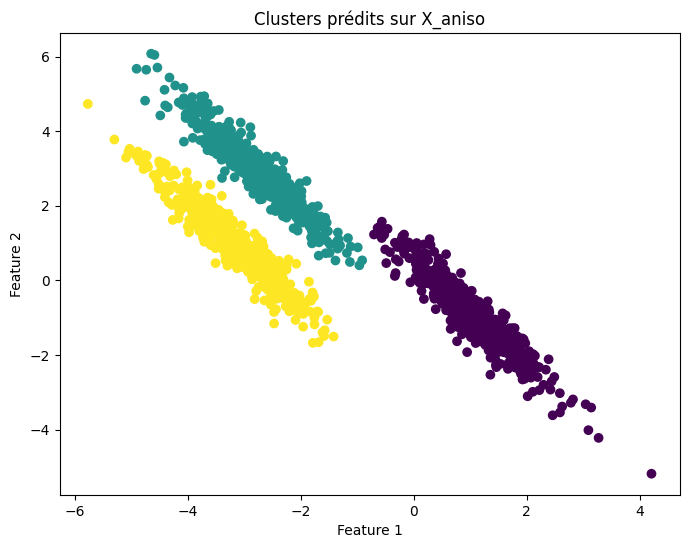

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal as mvn

# Assurez-vous que les fonctions nécessaires sont définies: fit, predict, predict_proba

# Génération des données
n_samples = 1500
random_state = 170
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_aniso = np.dot(X, transformation)  # Utilisation de X_aniso pour l'analyse GMM

# Paramètres du modèle GMM
K = 3  # Nombre de clusters
n_runs = 100  # Nombre d'itérations pour l'algorithme EM
epsilon = 1e-4  # Seuil de convergence

# Entraînement du modèle GMM
pi, mu, sigma = fit(X_aniso, n_runs)
print(pi, mu , sigma)
# Prédiction des étiquettes
labels = predict(X_aniso, K, pi, mu, sigma)
print(labels)
# Tracé des résultats
plt.figure(figsize=(8, 6))
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=labels, cmap='viridis')
plt.title("Clusters prédits sur X_aniso")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


C:\Users\raphv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\raphv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1420: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
C:\Users\raphv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(

Convergence reached at iteration 4.
Convergence reached at iteration 10.
Convergence reached at iteration 14.


C:\Users\raphv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\raphv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1420: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Convergence reached at iteration 4.


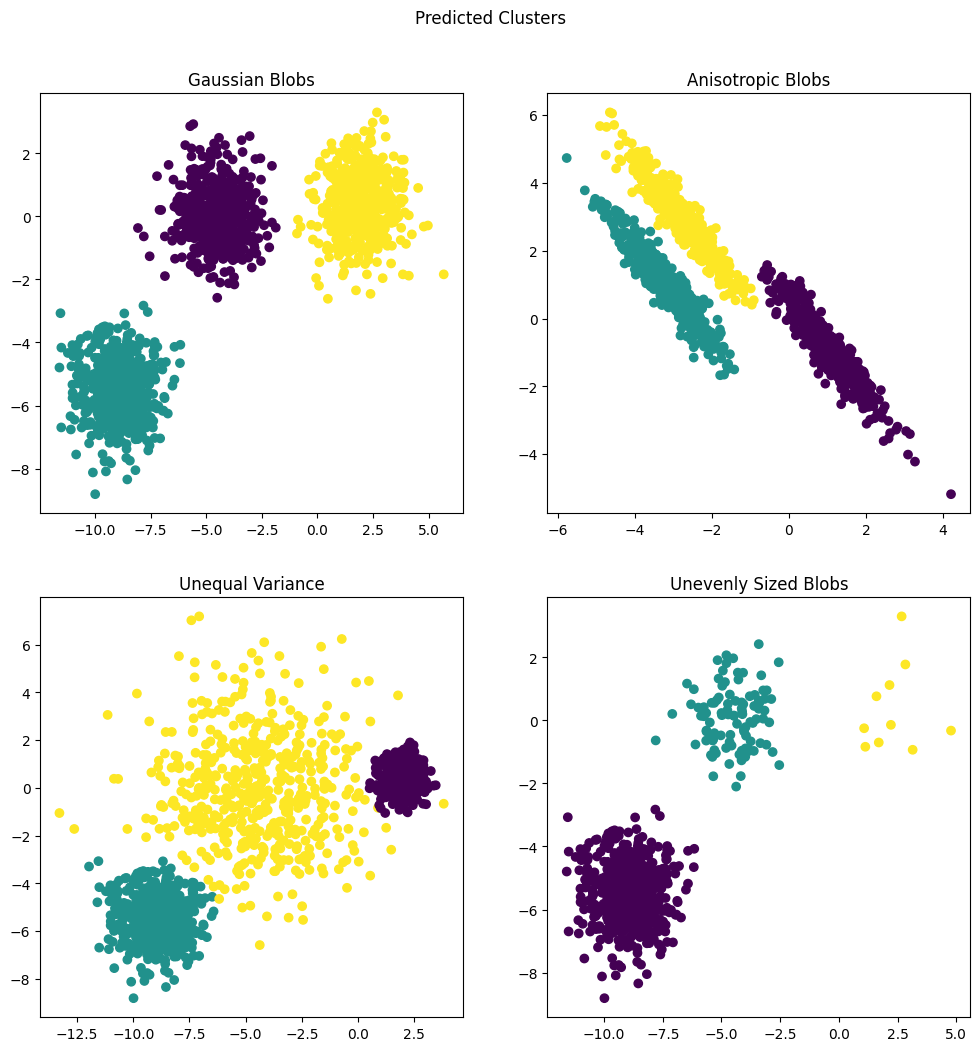

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal as mvn

# Ici, on suppose que les fonctions fit, predict et predict_proba sont déjà définies.

# Génération des données
n_samples = 1500
random_state = 170
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_aniso = np.dot(X, transformation)  # Anisotropic blobs
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)  # Variance inégale
X_filtered = np.vstack(
    (X[y == 0][:500], X[y == 1][:100], X[y == 2][:10])
)  # Blobs de tailles différentes
y_filtered = [0] * 500 + [1] * 100 + [2] * 10

# Paramètres pour GMM
K = 3  # Nombre de clusters
n_runs = 100  # Nombre d'itérations pour l'algorithme EM
epsilon = 1e-4  # Seuil de convergence

datasets = [X, X_aniso, X_varied, X_filtered]
titles = ["Gaussian Blobs", "Anisotropic Blobs", "Unequal Variance", "Unevenly Sized Blobs"]
results = []

# Appliquer fit et predict sur chaque dataset
for data in datasets:
    pi, mu, sigma = fit(data, n_runs)
    labels = predict(data, K, pi, mu, sigma)
    results.append(labels)

# Affichage des résultats
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    ax.scatter(datasets[i][:, 0], datasets[i][:, 1], c=results[i])
    ax.set_title(titles[i])

plt.suptitle("Predicted Clusters").set_y(0.95)
plt.show()


#### 6. Implement the GMM as a Python class

The previous steps helps you to understand the mechanism of GMM. However, the implementation style is pretty ugly and should be avoided.

Normally, we implement machine learning models by class, following Object-Oriented Programming concept.

The following schema helps to vitualize the attributes and methods of Class GMM

![picture](classes.png)

With this OOP design, the parameters pi, mu, sigma are attributes of the class, so you should use `self.pi`, `self.mu` and `self.sigma` to take or modify the values of these variables. E-step and M-step are private method, named as `_e_step()` and `_m_step()`. The prefix symbole `_` defines protected attributes/methods in python, making it only accessible from within the class. 


One you finish this class. Create a new python file `GMM.py` in the same directory of this Jupyter notebook file. Then, you can use your model by
```
from GMM import GMM
```

(This is optional. You will gain 2 point out of 10 for this lab session as bonus.)

In [32]:
class GMM:
    def __init__(self, K, n_runs=200):
        self.K = K
        self.n_runs = n_runs
        self.pi = None  # Initialisation des poids
        self.mu = None  # Initialisation des moyennes
        self.sigma = None  # Initialisation des covariances
    def calculate_mean_covariance(self, X, prediction):
        """Calculate means and covariance of different
            clusters from k-means prediction
        
        Parameters:
        ------------
        prediction: cluster labels from k-means
        
        X: N*d numpy array data points 
        
        Returns:
        -------------
        intial_means: for E-step of EM algorithm
        
        intial_cov: for E-step of EM algorithm
        
        """
        d = X.shape[1]
        labels = np.unique(prediction)
        self.initial_means = np.zeros((self.K, d))
        self.initial_cov = np.zeros((self.K, d, d))
        self.initial_pi = np.zeros(self.K)
        
        counter=0
        for label in labels:
            ids = np.where(prediction == label) # returns indices
            self.initial_pi[counter] = len(ids[0]) / X.shape[0]
            self.initial_means[counter,:] = np.mean(X[ids], axis = 0)
            de_meaned = X[ids] - self.initial_means[counter,:]
            Nk = X[ids].shape[0] # number of data points in current gaussian
            self.initial_cov[counter,:, :] = np.dot(self.initial_pi[counter] * de_meaned.T, de_meaned) / Nk
            counter+=1
        assert np.sum(self.initial_pi) == 1    
            
        return (self.initial_means, self.initial_cov, self.initial_pi)
    
    def _initialise_parameters(self, X):
        """Implement k-means to find startin parameter values.
            https://datascience.stackexchange.com/questions/11487/how-do-i-obtain-the-weight-and-variance-of-a-k-means-cluster

        Parameters:
        ------------
        X: numpy array of data points
        
        Returns:
        ----------
        tuple containing initial means and covariance
        
        _initial_means: numpy array: (K*d)
        
        _initial_cov: numpy array: (K,d*d)
        
        
        """
        n_clusters = self.K
        kmeans = KMeans(n_clusters= n_clusters, init="k-means++", max_iter=500, algorithm = 'auto')
        fitted = kmeans.fit(X)
        prediction = kmeans.predict(X)
        self.pi, self.mu, self.sigma = self.calculate_mean_covariance(X, prediction)
        
        
        return (self.pi, self.mu, self.sigma)

    def get_params(self):
        return (self.mu, self.pi, self.sigma)

    def _e_step(self, X):
        """Performs E-step on GMM model
        Parameters:
        ------------
        X: (N x d), data points, m: no of features
        pi: (K), weights of mixture components
        mu: (K x d), mixture component means
        sigma: (K x d x d), mixture component covariance matrices
        Returns:
        ----------
        gamma: (N x K), probabilities of clusters for objects
        """

        N = X.shape[0]
        self.gamma = np.zeros((N, self.K))

        for k in range(self.K):
            self.gamma[:, k] = self.pi[k] * mvn.pdf(X, self.mu[k], self.sigma[k])

        gamma_sum = np.sum(self.gamma, axis=1)[:, np.newaxis]
        self.gamma /= gamma_sum

        return self.gamma

    def _m_step(self, X):
        """Performs M-step of the GMM
        We need to update our priors, our means
        and our covariance matrix.
        Parameters:
        -----------
        X: (N x d), data
        gamma: (N x K), posterior distribution of lower bound
        Returns:
        ---------
        pi: (K)
        mu: (K x d)
        sigma: (K x d x d)
        """
        N = X.shape[0]
        d = X.shape[1]

        # Mise à jour des poids et des moyennes
        self.pi = np.sum(self.gamma, axis=0) / N
        self.mu = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis=0)[:, np.newaxis]

        # Mise à jour des covariances
        self.sigma = np.zeros((self.K, d, d))
        for k in range(self.K):
            X_centered = X - self.mu[k, :]
            gamma_diag = np.diag(self.gamma[:, k])
            self.sigma[k, :, :] = np.dot(X_centered.T, np.dot(gamma_diag, X_centered)) / np.sum(self.gamma, axis=0)[k]

        return self.pi, self.mu, self.sigma

    def fit(self, X):
        """Compute the E-step and M-step and
            Calculates the lowerbound

        Parameters:
        -----------
        X: (N x d), data

        Returns:
        ----------
        instance of GMM

        """

        self._initialise_parameters(X)

        for run in range(self.n_runs):
            self._e_step(X)
            self._m_step(X)

        # Ajouter un critère de convergence si nécessaire

        return self
        
    def predict(self, X):
        """Returns predicted labels using Bayes Rule to
        Calculate the posterior distribution

        Parameters:
        -------------
        X: ?*d numpy array

        Returns:
        ----------
        labels: predicted cluster based on
        highest responsibility gamma.

        """
        # Assurez-vous d'abord que gamma est à jour
        self._e_step(X)
        
        # Les étiquettes sont les indices des composants de mélange avec la plus grande probabilité pour chaque point
        labels = np.argmax(self.gamma, axis=1)
        
        return labels


        return labels
    def predict_proba(self, X):
        """Using Bayes Rule to Calculate the posterior distribution

        Parameters:
        -------------
        X: N*d numpy array

        Returns:
        ----------
        labels: predicted cluster based on
        highest responsibility gamma.

        """
        post_proba = np.zeros((X.shape[0], self.K))

        for k in range(self.K):
            # Posterior Distribution using Bayes Rule, try and vectorise
            post_proba[:,k] = self.pi[k] * mvn.pdf(X, self.mu[k,:], self.sigma[k])

        return post_proba
    

### Comparison with KNN (optional)

Compare the clustering results on the generated data between GMM and K-means method. You can simply plot the results of the two method. 
Use [k-means implemented in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) for comparison

In [1]:
from GMM import GMM

C:\Users\raphv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


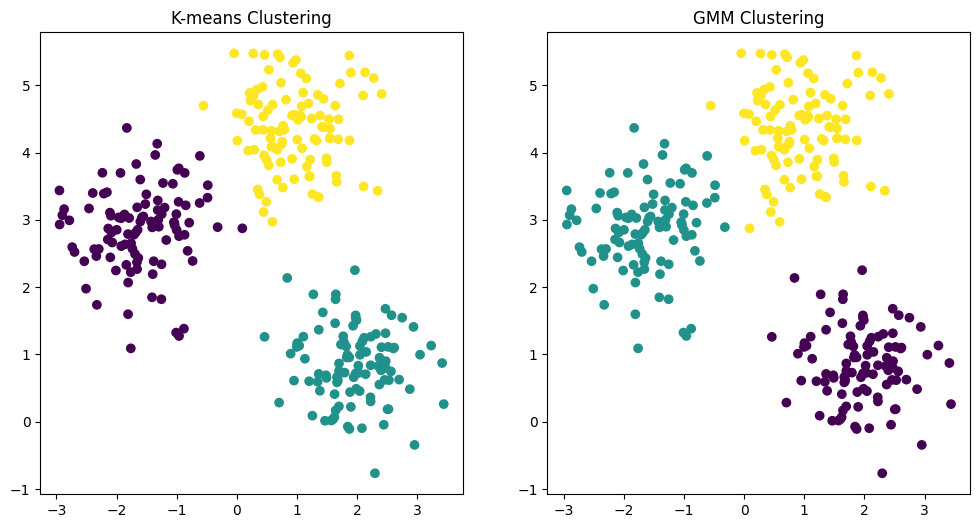

In [2]:

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Générer des données de test
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# Appliquer K-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans_labels = kmeans.predict(X)

# Appliquer GMM
gmm = GMM(K=3, n_runs=100)
gmm.fit(X)
gmm_labels = gmm.predict(X)

# Visualisation des résultats
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("K-means Clustering")

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis')
plt.title("GMM Clustering")

plt.show()